## Polarity is all you need to learn and transfer faster
This notebook is a tutorial for reproducing the XOR simulation results in **Polarity is all you need to learn and transfer faster**.  
* Data used in this notebook can be downloaded from OSF following this anonymized [link](https://osf.io/ayd6u/?view_only=6688f283d99840f994a4ed067b4bc939)
* All experiments and analysis were performed within the following docker environment, which could be setup as following. 
```setup
docker build -t weightpolarity .
docker run --gpus all -v ${PWD}:/workspace --name weightpolarity weightpolarity
```

## XOR-5D Simulation

### Experiments

#### 1. Generate training data with various training sample sizes
Can be found in folder **data**

In [1]:
config = {}
config['num_dim'] = 5
config['batch_size'] = 32
sample_size_list = [  8,  20, 32, 40, 52, 60, 72, 80, 92, 100, 500]
sample_size_val = 1000

In [2]:
from generators import generate_series_xper_samples
generate_series_xper_samples(sample_size_list, sample_size_val, config)

#### 2. Batch run experiments
* The experiments are set up to run in background in paralell. 
* You may choose to change the training sample size (sample_size_list), hidden size (hSize_list), and epoch number (num_epoch_list) configurations in batchcis.py. The current setup is for paper reproduction. 
* For data-informed freeze, run **--doRandInit 1**; For data-uninformed freeze, run **--doRandInit 0**. You may choose to change the baseFName accordingly. 
* You are suggested to run below lines in command line. 

In [3]:
# freeze-informed
!python batchcis.py --doRandInit 0 --num_gpu 1 --num_run 1 --baseFName 'ruleBasedFix' --resetType 'posRand'
!python sum_data.py --num_run 1 --baseFName 'ruleBasedFix' --resetType 'posRand'

  job_identifier  ...                check_path
0              0  ...   dim5posRands8e100r2run0
1              1  ...  dim5posRands20e100r2run0
2              2  ...  dim5posRands32e100r2run0
3              3  ...  dim5posRands40e100r2run0
4              4  ...  dim5posRands52e100r2run0

[5 rows x 6 columns]


In [4]:
# freeze-uninformed
!python batchcis.py --doRandInit 1 --num_gpu 1 --num_run 1 --baseFName 'randInit' --resetType 'posRand'
!python sum_data.py --num_run 1 --baseFName 'randInit' --resetType 'posRand'

  job_identifier  ...                check_path
0              0  ...   dim5posRands8e100r2run0
1              1  ...  dim5posRands20e100r2run0
2              2  ...  dim5posRands32e100r2run0
3              3  ...  dim5posRands40e100r2run0
4              4  ...  dim5posRands52e100r2run0

[5 rows x 6 columns]


### Analysis

#### 1.Preparation - load necessary packages and helper functions

In [5]:
import matplotlib.pyplot as plt
import os
import pickle as pickle
import pandas as pd
import numpy as np
import matplotlib as matplotlib

In [6]:
# white background
plt.rcParams.update({
    "lines.color": "black",
    "patch.edgecolor": "black",
    "text.color": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "black",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "grid.color": "lightgray"})

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
from plots import dict_to_query, plot_median_plus_example, simpleaxis

In [9]:
def paint_color(x, y):
    if x > 0:
        if y > 0:
            return np.array(3)
        else:
            return np.array(2)
    else:
        if y > 0:
            return np.array(1)
        else:
            return np.array(0)
np_paint_color = np.vectorize(paint_color, otypes = [np.ndarray])

#### 2.Load Data
* Here, we will use experiment data presented in the manuscript. They are presented in the main text, each experiment was ran for 50 repeats

In [13]:
config = {}
config['batch_size'] = 32

doWeightFreeze_list = [True, False]
sample_size_list = [  8,  20, 32, 40, 52, 60, 72, 80, 92, 100, 500]
num_epoch_list = [100] * len(sample_size_list)
num_dim_list = [2,5]
hSize_list = list(range(2,30))  + [30,32,48,64] 

numVal = 1000
numRun = 50 #20 if plotting for supplementary figure
resetType_list = ['posRand'] #'posCon', , 'zero', 'flip'

In [14]:
baseFName = 'ruleBasedFix'
f_name = os.path.join(os.getcwd(), 'manuscript_data', baseFName, 'epoch_acc_loss_main.pkl')
with open(f_name, 'rb') as f:
    metrics_smart = pickle.load(f)

baseFName = 'randInit'
f_name = os.path.join(os.getcwd(), 'manuscript_data', baseFName, 'epoch_acc_loss_main.pkl')
with open(f_name, 'rb') as f:
    metrics_dumb = pickle.load(f)

In [15]:
print(metrics_dumb.shape)
print(metrics_dumb['train_acc'][0].shape)

(1408, 12)
(50, 100)


#### 3.**DATA: Statistical Efficiency** - Figure 1.C, Figure 4.B&C third column

##### Load functions

In [16]:
def get_converge_epoch(x):
    epoch_num = np.squeeze(np.where(x == np.amin(x)))
    if not len(epoch_num.shape)==0:
        epoch_num = epoch_num[0]
    return epoch_num

In [17]:
def get_acc_at_conver(val_acc, val_loss):
    # both are matrices with rows as run
    epoch_at_conver = np.apply_along_axis(get_converge_epoch, 1, val_loss)
    acc_at_conver = np.squeeze(np.take_along_axis(val_acc, np.expand_dims(epoch_at_conver, axis=1), axis=1))
    # print(epoch_at_conver.shape)
    # print(acc_at_conver.shape)    
    return acc_at_conver, epoch_at_conver

In [18]:
def get_conver(metrics, doWeightFreeze_list, resetType_list, hSize_infocus, numRun):
    conver = pd.DataFrame(index=range(len(doWeightFreeze_list)*len(resetType_list)), columns=["typeStr", "resetType", "hiddenSize", "acc", "epoch"])

    for ridx, resetType in enumerate(resetType_list):
        for didx, doWeightFreeze in enumerate(doWeightFreeze_list):
            df_loc = ridx*len(doWeightFreeze_list)+didx
            if doWeightFreeze:
                typeStr = 'freeze'
                typeStr_dict = '\'freeze\''
            else:
                typeStr = 'liquid'
                typeStr_dict = '\'liquid\''
            conver['typeStr'][df_loc] = typeStr
            conver['resetType'][df_loc] = resetType
            conver['hiddenSize'][df_loc] = hSize_infocus

            # get different sample sizes into list
            page_dict = {'num_dim':5, 'hiddenSize':hSize_infocus, 'typeStr':typeStr_dict, 'resetType':'\''+ resetType +'\''}
            val_loss = metrics.query(dict_to_query(page_dict))['validation_loss'].tolist()
            val_acc = metrics.query(dict_to_query(page_dict))['validation_acc'].tolist()
            # print(val_acc[0].shape)

            acc_at_conver = np.empty(shape=(len(sample_size_list), numRun))
            epoch_at_conver = np.empty(shape=(len(sample_size_list), numRun))
            for idx, (this_val_loss, this_val_acc) in enumerate(zip(val_loss, val_acc)):
                this_acc_at_conver, this_epoch_at_conver = get_acc_at_conver(this_val_acc, this_val_loss)
                acc_at_conver[idx, :] = this_acc_at_conver
                epoch_at_conver[idx, :] = this_epoch_at_conver
                # print('sample size %d is done' % idx)
            conver['acc'][df_loc] = np.transpose(acc_at_conver)
            conver['epoch'][df_loc] = np.transpose(epoch_at_conver)
    return conver

In [19]:
def get_stack_flops(flops, typeStr, acc, colName):
    return np.squeeze(np.stack([np.stack(flops.query(dict_to_query({'typeStr':'\''+typeStr+'\'', 'acc':acc, 'hiddenSize':hiddenSize}))[colName].tolist()) for hiddenSize in hSize_list]))

In [20]:
def get_stack_conver(conver, typeStr, colName):
    return np.squeeze(np.stack([np.stack(conver.query(dict_to_query({'typeStr':'\''+typeStr+'\'', 'hiddenSize':hiddenSize}))[colName].tolist()) for hiddenSize in hSize_list]))

##### Below cell plot for Figure 1.C, Figure 4.B&C third column

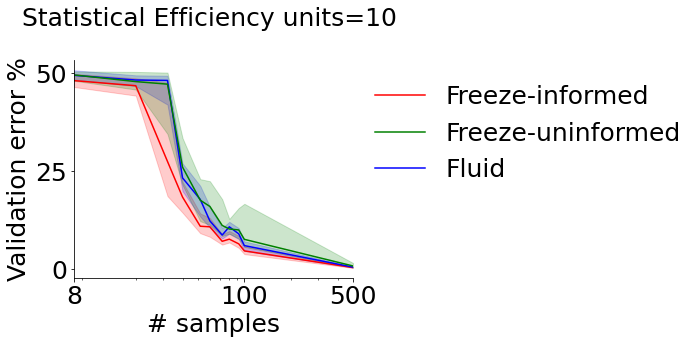

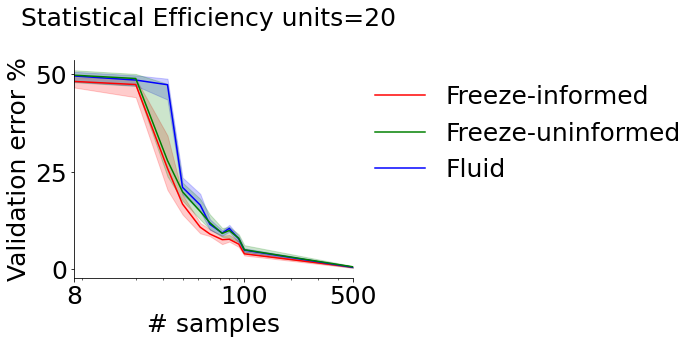

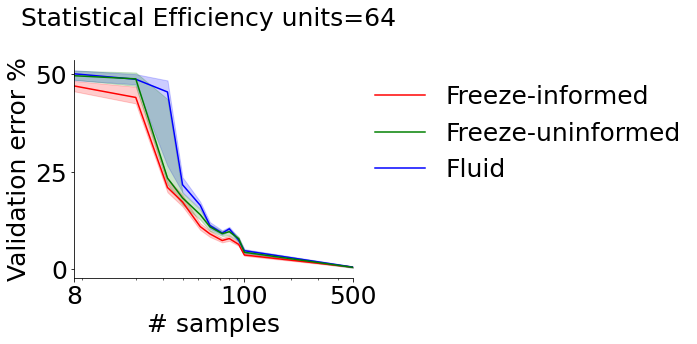

In [21]:
fontsize=25
resetType_list = ['posRand']
for resetType in resetType_list:
    for hSize_infocus in [10,20,64]:
        conver_smart = get_conver(metrics_smart, doWeightFreeze_list, resetType_list, hSize_infocus, numRun)
        conver_dumb = get_conver(metrics_dumb, doWeightFreeze_list, resetType_list, hSize_infocus, numRun)
        fig = plt.figure(figsize=(5,4))

        thisAx = plt.gca()
        doExample = False
        x_coord = np.array(sample_size_list)
        xlim=[np.min(x_coord), np.max(x_coord)]
        ylim=0
        color_list = ['r','b','g']

        for didx, doWeightFreeze in enumerate(doWeightFreeze_list):
            if doWeightFreeze:
                typeStr = 'Freeze-informed'
                typeStr_dict = '\'freeze\''
            else:
                typeStr = 'Fluid'
                typeStr_dict = '\'liquid\''

            x_mat = conver_smart.query(dict_to_query({'typeStr':typeStr_dict, 'resetType':'\''+resetType+'\''}))['acc'].tolist()[0]
            plot_median_plus_example((1-x_mat)*100, x_coord, ylim, xlim, typeStr, doExample, thisAx, color=color_list[didx])

        x_mat = conver_dumb.query(dict_to_query({'typeStr':'\'freeze\'', 'resetType':'\''+resetType+'\''}))['acc'].tolist()[0]
        plot_median_plus_example((1-x_mat)*100, x_coord, ylim, xlim, 'Freeze-uninformed', doExample, thisAx, color=color_list[2])

        simpleaxis(thisAx)
        thisAx.set_xscale('log')
        thisAx.set_xticks([8,100,500]) 
        thisAx.set_xticklabels(['%d' % x for x in [8,100,500]], fontsize=fontsize)
        thisAx.set_yticks([0,25,50], ['%d' % x for x in [0,25,50]], fontsize=fontsize)
        thisAx.set_xlabel('# samples', fontsize=fontsize)
        thisAx.set_ylabel('Validation error %', fontsize=fontsize)
        handles, labels = thisAx.get_legend_handles_labels()
        fig.text(0.5,1,'Statistical Efficiency units=%d' % hSize_infocus, ha='center', fontsize=fontsize)
 
        by_label = {labels[i]:handles[i] for i in [0,2,1]}
        lgd = thisAx.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1,.99), fancybox=True, framealpha=0, fontsize=fontsize)

##### Below 2 cells plot for Figure 4.D third column

In [22]:
resetType_list = ['posRand']
conver_smart = pd.concat([get_conver(metrics_smart, doWeightFreeze_list, resetType_list, hSize_infocus, numRun) for hSize_infocus in hSize_list], ignore_index=True)
conver_dumb = pd.concat([get_conver(metrics_dumb, doWeightFreeze_list, resetType_list, hSize_infocus, numRun) for hSize_infocus in hSize_list], ignore_index=True)
smart_conver_stack = {}
dumb_conver_stack = {}
for typeStr in ['freeze', 'liquid']:
    smart_conver_stack[typeStr] = get_stack_conver(conver_smart, typeStr, 'acc')
    dumb_conver_stack[typeStr] = get_stack_conver(conver_dumb, typeStr, 'acc')
# higher the better
smart_diff = np.median(smart_conver_stack['freeze'],axis=1) - np.median(smart_conver_stack['liquid'],axis=1)
dumb_diff = np.median(dumb_conver_stack['freeze'],axis=1) - np.median(dumb_conver_stack['liquid'],axis=1)

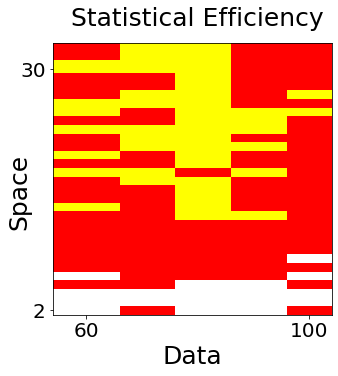

In [23]:
fig = plt.figure(figsize=(5,5))
rect = fig.patch
rect.set_alpha(0)
fontsize = 25
labelsize=20

abs_max=3
norm = matplotlib.colors.Normalize(vmin=0, vmax=abs_max)
cmap = matplotlib.colors.ListedColormap(['white', 'green', 'red', "yellow"])

ax = fig.add_subplot(1,1,1)
rect = ax.patch
ax.set_alpha(0)

color_dumb = np.squeeze(dumb_diff[:-2,5:-1])>0
color_smart = np.squeeze(smart_diff[:-2,5:-1])>0
color_mat = np.array(np_paint_color(color_smart, color_dumb).tolist())

X = np.array(sample_size_list[5:-1])
Y = np.array(hSize_list[:-2])
X, Y = np.meshgrid(X, Y)
ax.pcolormesh(X, Y, norm(color_mat), cmap = cmap)
ax.text(80,35,'Statistical Efficiency', fontsize=fontsize, ha='center')
ax.set_xticks([60,100], ['{num:d}'.format(num=num) for num in [60,100]], fontsize=labelsize) # 
ax.set_yticks([2,30], ['{num:d}'.format(num=num) for num in [2,30]], fontsize=labelsize) # 

ax.set_xlabel('Data', fontsize=fontsize)
ax.text(48,12,'Space', fontsize=fontsize, rotation=90, ha='center');

#### 4.**TIME: Computational Efficiency** - Figure 1.B, Figure 4.B&C second column

##### Load func

In [24]:
def get_learnt_epoch(x, cutoff):
    epoch_num = np.squeeze(np.where(x >= cutoff))
    if not len(epoch_num.shape) == 0: # only has single element
        if epoch_num.shape[0]==0:
            epoch_num = np.NaN
        else:
            epoch_num = epoch_num[0].astype(np.float64)
    else:
        epoch_num = epoch_num.astype(np.float64)
    return epoch_num

In [25]:
def get_flops(metrics, doWeightFreeze_list, acc_cutoff_list, resetType_list, hSize_infocus, numRun):
    flops = pd.DataFrame(index=range(len(doWeightFreeze_list)*len(acc_cutoff_list)*len(resetType_list)), columns=["typeStr", "resetType", "hiddenSize", "acc", "epoch", "flops"])
    counter = 0

    for resetType in resetType_list:
        for acc_cutoff in acc_cutoff_list:
            for doWeightFreeze in doWeightFreeze_list:
                if doWeightFreeze:
                    typeStr = 'freeze'
                    typeStr_dict = '\'freeze\''
                else:
                    typeStr = 'liquid'
                    typeStr_dict = '\'liquid\''
                flops['typeStr'][counter] = typeStr
                flops['acc'][counter] = acc_cutoff
                flops['resetType'][counter] = resetType
                flops['hiddenSize'][counter] = hSize_infocus

                # get different sample sizes into list
                page_dict = {'num_dim':5, 'hiddenSize':hSize_infocus, 'typeStr':typeStr_dict, 'resetType':'\'' + resetType + '\''} #, 'train_sample':sample_size_list[8]
                val_acc = metrics.query(dict_to_query(page_dict))['validation_acc'].tolist()
                # print(val_acc[0].shape)

                epoch_at_learnt = np.empty(shape=(len(sample_size_list), numRun), dtype=np.float64)
                for idx, this_val_acc in enumerate(val_acc):
                    this_epoch_at_learnt = np.apply_along_axis(get_learnt_epoch, 1, this_val_acc, acc_cutoff)
                    epoch_at_learnt[idx, :] = np.squeeze(this_epoch_at_learnt)
                    del this_epoch_at_learnt
                flops['epoch'][counter] = np.transpose(epoch_at_learnt)
                flops['flops'][counter] = flops['epoch'][counter]*hSize_infocus*3
                counter+=1
        # print('@acc %1.2f is done' % acc_cutoff)
    return flops

##### Below cell plot for Figure 1.B, Figure 4.B&C second column

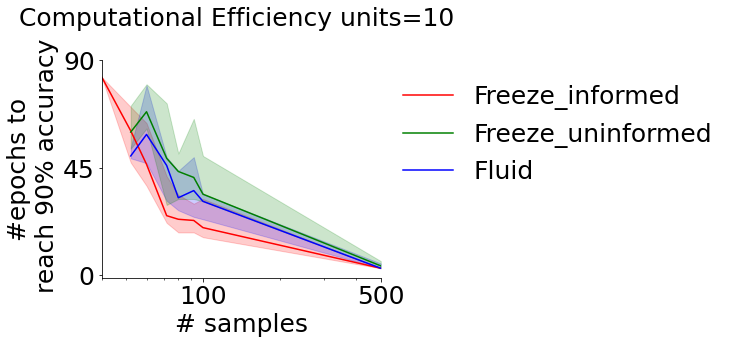

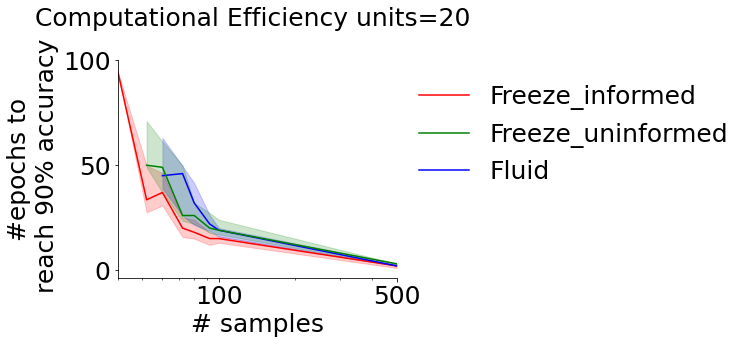

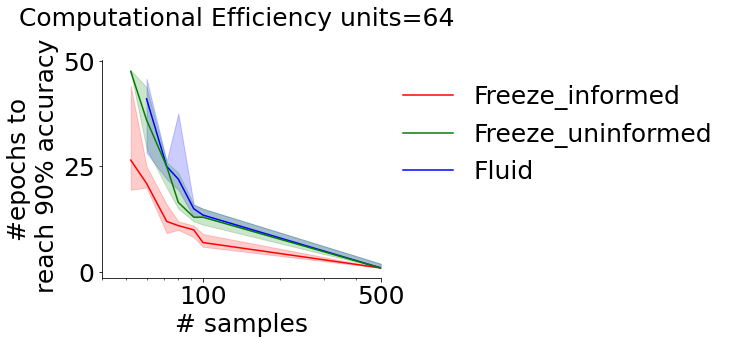

In [26]:
acc_cutoff_list=[0.9]
colName = 'epoch'
doTitle = False
resetType_list = ['posRand']
for resetType in resetType_list:
    for hSize_infocus in [10,20,64]:
        flops_smart = get_flops(metrics_smart, doWeightFreeze_list, acc_cutoff_list, resetType_list, hSize_infocus, numRun)
        flops_dumb = get_flops(metrics_dumb, doWeightFreeze_list, acc_cutoff_list, resetType_list, hSize_infocus, numRun)
        fig = plt.figure(figsize=(5,4))

        thisAx = plt.gca()
        fontsize=25
        doExample = False
        x_coord = np.array(sample_size_list)
        xlim=[40, np.max(x_coord)]
        ylim=0
        lineTypeList = ['-', '--']
        lineType = '-'
        color_list = ['r','b','g']

        for acc_cutoff, color in zip(acc_cutoff_list, color_list[2:]):
            for doWeightFreeze, color in zip(doWeightFreeze_list, color_list[:2]):
                if doWeightFreeze:
                    typeStr = 'Freeze_informed'
                    typeStr_dict = '\'freeze\''
                else:
                    typeStr = 'Fluid'
                    typeStr_dict = '\'liquid\''

                x_mat = flops_smart.query(dict_to_query({'typeStr':typeStr_dict, 'acc':acc_cutoff, 'resetType': '\''+ resetType + '\''}))[colName].tolist()[0]
                plot_median_plus_example(x_mat, x_coord, ylim, xlim, typeStr, doExample, thisAx, color=color, lineType=lineType)

            x_mat = flops_dumb.query(dict_to_query({'typeStr':'\'freeze\'', 'acc':acc_cutoff, 'resetType': '\''+ resetType + '\''}))[colName].tolist()[0]
            plot_median_plus_example(x_mat, x_coord, ylim, xlim, 'Freeze_uninformed', doExample, thisAx, color=color_list[2], lineType=lineType)

        simpleaxis(thisAx)
        thisAx.set_xscale('log')
        thisAx.set_xticks([100,500])#x_coord
        thisAx.set_xticklabels(['%d' % x for x in [100,500]], fontsize=fontsize)#

        y_min, y_max = thisAx.get_ylim()
        thisAx.set_yticks([0,round(y_max, -1)/2,round(y_max, -1)], ['%d' % x for x in [0,round(y_max, -1)/2,round(y_max, -1)]], fontsize=fontsize)
        thisAx.set_xlim(xlim)
        thisAx.set_xlabel('# samples', fontsize=fontsize)
        thisAx.set_ylabel('#'+colName+'s to\n reach %d%% accuracy' % int(acc_cutoff*100), fontsize=fontsize)

        if doTitle:
            y_min, y_max = thisAx.get_ylim()
            thisAx.text(100, y_max*1.05, resetType,fontweight="bold",fontsize=fontsize, ha='center')

        handles, labels = thisAx.get_legend_handles_labels()
        fig.text(0.5,1,'Computational Efficiency units=%d' % hSize_infocus, ha='center', fontsize=25)

        by_label = {labels[i]:handles[i] for i in [0,2,1]}
        lgd = thisAx.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1,.99), fancybox=True, framealpha=0, fontsize=25)

##### Below 2 cells plot for Figure 4.D second column

In [27]:
acc_cutoff_list = [0.9]
resetType_list = ['posRand']
flops_smart = pd.concat([get_flops(metrics_smart, doWeightFreeze_list, acc_cutoff_list, resetType_list, hSize_infocus, numRun) for hSize_infocus in hSize_list], ignore_index=True)
flops_dumb = pd.concat([get_flops(metrics_dumb, doWeightFreeze_list, acc_cutoff_list, resetType_list, hSize_infocus, numRun) for hSize_infocus in hSize_list], ignore_index=True)
smart_flops_stack = {}
dumb_flops_stack = {}
for typeStr in ['freeze', 'liquid']:
    smart_flops_stack[typeStr] = get_stack_flops(flops_smart, typeStr, 0.9, 'epoch')
    dumb_flops_stack[typeStr] = get_stack_flops(flops_dumb, typeStr, 0.9,'epoch')
# lower the better
smart_diff = np.nanmedian(smart_flops_stack['liquid'],axis=1) - np.nanmedian(smart_flops_stack['freeze'],axis=1)
dumb_diff = np.nanmedian(smart_flops_stack['liquid'],axis=1) - np.nanmedian(dumb_flops_stack['freeze'],axis=1)

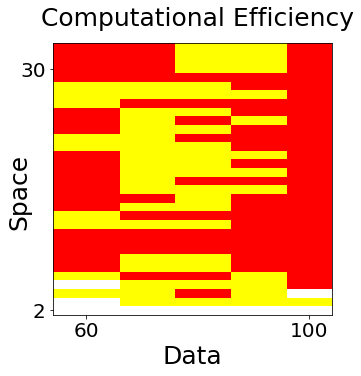

In [28]:
fig = plt.figure(figsize=(5,5))
rect = fig.patch
rect.set_alpha(0)
fontsize = 25
labelsize=20

abs_max=3
norm = matplotlib.colors.Normalize(vmin=0, vmax=abs_max)
cmap = matplotlib.colors.ListedColormap(['white', 'green', 'red', "yellow"])

ax = fig.add_subplot(1,1,1)
rect = ax.patch
ax.set_alpha(0)

color_dumb = np.squeeze(dumb_diff[:-2,5:-1])>0
color_smart = np.squeeze(smart_diff[:-2,5:-1])>0
color_mat = np.array(np_paint_color(color_smart, color_dumb).tolist())

X = np.array(sample_size_list[5:-1])
Y = np.array(hSize_list[:-2])
X, Y = np.meshgrid(X, Y)
ax.pcolormesh(X, Y, norm(color_mat), cmap = cmap)
ax.text(80,35,'Computational Efficiency', fontsize=fontsize, ha='center')
ax.set_xticks([60,100], ['{num:d}'.format(num=num) for num in [60,100]], fontsize=labelsize) # 
ax.set_yticks([2,30], ['{num:d}'.format(num=num) for num in [2,30]], fontsize=labelsize) # 

ax.set_xlabel('Data', fontsize=fontsize)
ax.text(48,12,'Space', fontsize=fontsize, rotation=90, ha='center');

#### 5.**SPACE: Network Size** - Figure 4A, Figure 4.B&C first column

##### Load func

In [29]:
def get_prob_sim(metrics, numRun, typeStr, sample_size_list, acc_cutoff):
    return np.stack([[np.sum(np.any(this_metric>acc_cutoff, axis=1))/numRun for this_metric in metrics.query(dict_to_query({'num_dim':5, 'resetType':'\'posRand\'', 'typeStr':'\''+typeStr+'\'', 'train_sample':train_sample}))['validation_acc'].tolist()] for train_sample in sample_size_list])

##### Below 3 cells plot for Figure 4A

In [30]:
from scipy.special import comb
def Q_fun(k, m, n, M):
    if k==0:
        return M**n
    else:
        return comb(m, k)*((M+k)**n - sum([Q_fun(p, k, n, M) for p in range(0, k)]))

def get_theor_prob(k, m, n, M):
    return 1 - (sum([Q_fun(p,  m, n, M) for p in range(0, k)]))/((m+M)**n) #

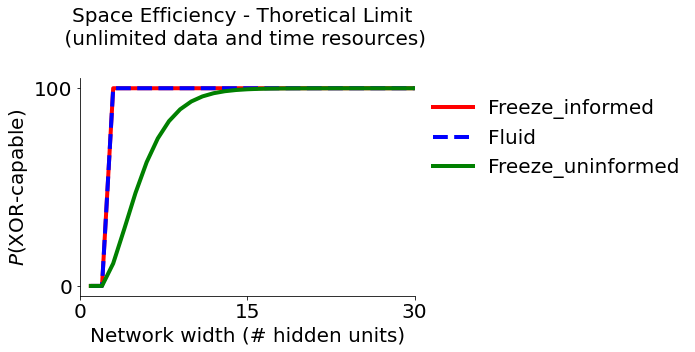

In [31]:
fig = plt.figure()
fontsize=20
x_l = range(1,31)

y_l = {}
y_l['Freeze_uninformed'] = np.array([get_theor_prob(3, 32, n, 32) for n in x_l])
y_l['Freeze_informed'] = np.array([0,0]+[1]*28)
y_l['Fluid'] = np.array([0,0]+[1]*28)

plt.plot(x_l, y_l['Freeze_informed']*100, label='Freeze_informed', color='r', linewidth=4)
plt.plot(x_l, y_l['Fluid']*100, '--', label='Fluid', color='b', linewidth=4)
plt.plot(x_l, y_l['Freeze_uninformed']*100, label='Freeze_uninformed', color='g', linewidth=4)

plt.xlim([0,30])
plt.xlabel('Network width (# hidden units)', fontsize=fontsize)
plt.ylabel('$P$(XOR-capable)', fontsize=fontsize)
plt.xticks([0,15,30], fontsize=fontsize)
plt.yticks([0,100], fontsize=fontsize)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
handles, labels = plt.gca().get_legend_handles_labels()
rect = plt.gca().patch
rect.set_alpha(0)
fig.text(.5,1,'Space Efficiency - Thoretical Limit\n (unlimited data and time resources)', ha='center', fontsize=fontsize)

by_label = {labels[i]:handles[i] for i in [0,1,2]}
lgd = plt.gca().legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1,.99), fancybox=True, framealpha=0, fontsize=fontsize)

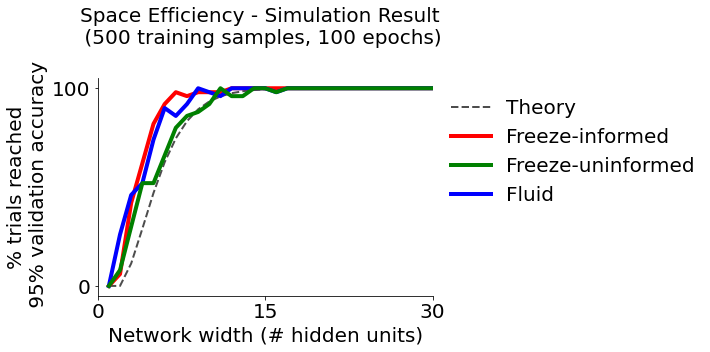

In [32]:
fig = plt.figure()
fontsize=20
acc_cutoff = 0.95
x_l = range(1,31)
train_sample = 500

y_l = {}
y_l['Freeze_uninformed'] = [np.sum(np.any(this_metric>acc_cutoff, axis=1))/numRun for this_metric in metrics_dumb.query(dict_to_query({'num_dim':5, 'resetType':'\'posRand\'', 'typeStr':'\'freeze\'', 'train_sample':train_sample}))['validation_acc'].tolist()]
y_l['Freeze_informed'] = [np.sum(np.any(this_metric>acc_cutoff, axis=1))/numRun for this_metric in metrics_smart.query(dict_to_query({'num_dim':5, 'resetType':'\'posRand\'', 'typeStr':'\'freeze\'', 'train_sample':train_sample}))['validation_acc'].tolist()]
y_l['Fluid'] = [np.sum(np.any(this_metric>acc_cutoff, axis=1))/numRun for this_metric in metrics_smart.query(dict_to_query({'num_dim':5, 'resetType':'\'posRand\'', 'typeStr':'\'liquid\'', 'train_sample':train_sample}))['validation_acc'].tolist()]

plt.plot(x_l, np.array([get_theor_prob(3, 32, n, 32) for n in x_l])*100, '--', label='Theory', color=[0.3,0.3,0.3], linewidth=2)
plt.plot(x_l, 100*np.array(y_l['Freeze_informed'][:30]), label='Freeze-informed', color='r', linewidth=4)
plt.plot(x_l, 100*np.array(y_l['Fluid'][:30]), label='Fluid', color='b', linewidth=4)
plt.plot(x_l, 100*np.array(y_l['Freeze_uninformed'][:30]), label='Freeze-uninformed', color='g', linewidth=4)

plt.xlim([0,30])
plt.xlabel('Network width (# hidden units)', fontsize=fontsize)
plt.ylabel('%% trials reached\n %d%% validation accuracy' % int(acc_cutoff*100), fontsize=fontsize)
plt.xticks([0,15,30], fontsize=fontsize)
plt.yticks([0,100], fontsize=fontsize)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
handles, labels = plt.gca().get_legend_handles_labels()
rect = plt.gca().patch
rect.set_alpha(0)
fig.text(.5,1,'Space Efficiency - Simulation Result\n (%d training samples, 100 epochs)' % train_sample, ha='center', fontsize=fontsize)

by_label = {labels[i]:handles[i] for i in [0,1,3,2]}
lgd = plt.gca().legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1,.99), fancybox=True, framealpha=0, fontsize=fontsize)

##### Below cell plot for Figure 4.B&C first column

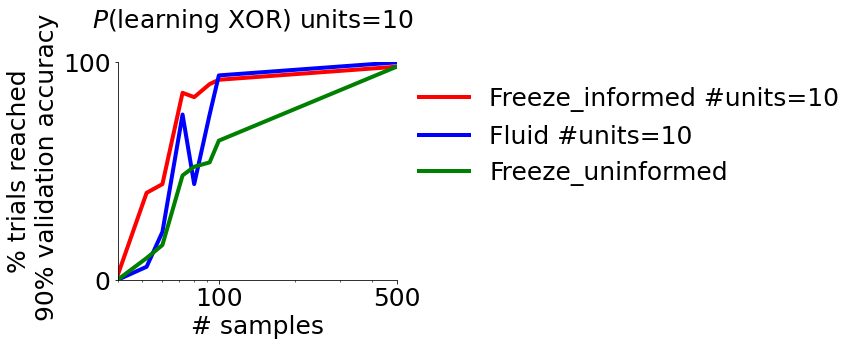

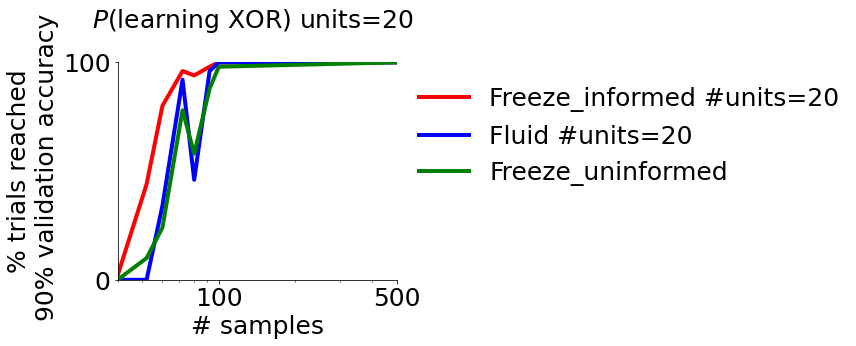

In [33]:
resetType_list = ['posRand']
lineStyle_list = ['-']
for hSize_infocus in [10,20]:
    for resetType in resetType_list:
        smart_size = hSize_infocus
        dumb_size_list = [hSize_infocus]
        fig = plt.figure(figsize=(5,4))
        acc_cutoff = 0.9
        fontsize=25
        x_l = sample_size_list

        y_l = {}
        y_l['Freeze_informed'] = [np.sum(np.any(this_metric>acc_cutoff, axis=1))/numRun for this_metric in metrics_smart.query(dict_to_query({'num_dim':5, 'resetType':'\''+resetType+'\'', 'typeStr':'\'freeze\'', 'hiddenSize':smart_size}))['validation_acc'].tolist()]
        y_l['Fluid'] = [np.sum(np.any(this_metric>acc_cutoff, axis=1))/numRun for this_metric in metrics_smart.query(dict_to_query({'num_dim':5, 'resetType':'\''+resetType+'\'', 'typeStr':'\'liquid\'', 'hiddenSize':smart_size}))['validation_acc'].tolist()]

        plt.plot(x_l, np.array(y_l['Freeze_informed'])*100, label='Freeze_informed #units=%d' % smart_size, color='r', linewidth=4)
        plt.plot(x_l, np.array(y_l['Fluid'])*100, label='Fluid #units=%d' % smart_size, color='b', linewidth=4)
        for dumb_size, lineStyle in zip(dumb_size_list, lineStyle_list):
            y_l['Freeze_uninformed'] = [np.sum(np.any(this_metric>acc_cutoff, axis=1))/numRun for this_metric in metrics_dumb.query(dict_to_query({'num_dim':5, 'resetType':'\''+resetType+'\'', 'typeStr':'\'freeze\'', 'hiddenSize':dumb_size}))['validation_acc'].tolist()]
            if dumb_size > 20:
                plt.plot(x_l, np.array(y_l['Freeze_uninformed'])*100, lineStyle, label='Freeze_uninformed', color='g', linewidth=4)
            else:
                plt.plot(x_l,np.array( y_l['Freeze_uninformed'])*100, lineStyle, label='Freeze_uninformed', color='g', linewidth=4)

        # plt.title('Probability of \n random freeze network can solve XOR\n', fontweight='bold', fontsize=16)
        plt.xlim([40,500])
        plt.ylim([0,100])
        plt.xlabel('# samples', fontsize=fontsize)
        plt.ylabel('%% trials reached\n %d%% validation accuracy' % int(acc_cutoff*100), fontsize=fontsize)

        plt.gca().set_xscale('log')
        plt.gca().set_xticks([100,500])#x_coord
        plt.gca().set_xticklabels(['%d' % x for x in [100,500]], fontsize=fontsize)#
        plt.yticks([0,100], fontsize=fontsize)
        # plt.grid(True)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        # plt.gca().legend(loc='upper right', bbox_to_anchor=[1,.95], fancybox=True, framealpha=0)
        handles, labels = plt.gca().get_legend_handles_labels()
        rect = plt.gca().patch
        rect.set_alpha(0)
        fig.text(.5,1,'$P$(learning XOR) units=%d' % hSize_infocus, ha='center', fontsize=fontsize)

        by_label = {labels[i]:handles[i] for i in [0,1,2]}
        lgd = plt.gca().legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1,.99), fancybox=True, framealpha=0, fontsize=fontsize)

##### Below 2 cells plot for Figure 4.D first column

In [34]:
smart_prob_stack = {}
dumb_prob_stack = {}
acc_cutoff = 0.9
for typeStr in ['freeze', 'liquid']:
    smart_prob_stack[typeStr] = get_prob_sim(metrics_smart, numRun, typeStr, sample_size_list, acc_cutoff).T
    dumb_prob_stack[typeStr] = get_prob_sim(metrics_dumb, numRun, typeStr, sample_size_list, acc_cutoff).T
# higher the better
smart_diff = smart_prob_stack['freeze'] - smart_prob_stack['liquid']
dumb_diff = dumb_prob_stack['freeze'] - dumb_prob_stack['liquid']

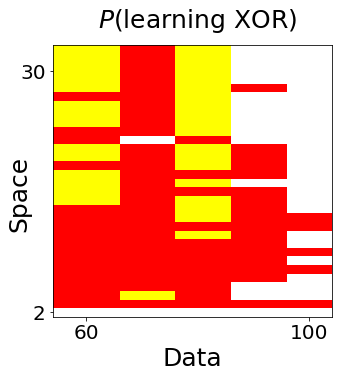

In [35]:
fig = plt.figure(figsize=(5,5))
rect = fig.patch
rect.set_alpha(0)
fontsize = 25
labelsize=20

abs_max=3
norm = matplotlib.colors.Normalize(vmin=0, vmax=abs_max)
cmap = matplotlib.colors.ListedColormap(['white', 'green', 'red', "yellow"])

ax = fig.add_subplot(1,1,1)
rect = ax.patch
ax.set_alpha(0)

color_dumb = np.squeeze(dumb_diff[:-2,5:-1])>0
color_smart = np.squeeze(smart_diff[:-2,5:-1])>0
color_mat = np.array(np_paint_color(color_smart, color_dumb).tolist())

X = np.array(sample_size_list[5:-1])
Y = np.array(hSize_list[:-2])
X, Y = np.meshgrid(X, Y)
ax.pcolormesh(X, Y, norm(color_mat), cmap = cmap)
ax.text(80,35,'$P$(learning XOR)', fontsize=fontsize, ha='center')
ax.set_xticks([60,100], ['{num:d}'.format(num=num) for num in [60,100]], fontsize=labelsize) # 
ax.set_yticks([2,30], ['{num:d}'.format(num=num) for num in [2,30]], fontsize=labelsize) # 

ax.set_xlabel('Data', fontsize=fontsize)
ax.text(48,12,'Space', fontsize=fontsize, rotation=90, ha='center');